In [1]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image

import h5py
import torch
import torch.nn as nn
from torchvision.models import resnet50, vit_b_16
import torchvision.transforms as transforms
from glob import glob 


image_file = '../../../pcam/training_split.h5'
label_file = '../../../Labels/Labels/camelyonpatch_level_2_split_train_y.h5'

with h5py.File(image_file, 'r') as f:
    images = f['x'][:]
with h5py.File(label_file, 'r') as f:
    labels = f['y'][:].reshape(-1,)

In [2]:
# positive_indices = np.random.choice(np.where(labels == 1)[0], 5, replace=False)
# negative_indices = np.random.choice(np.where(labels == 0)[0], 5, replace=False)

positive_indices = [258358, 161909, 231973, 233026, 115436]
negative_indices = [48297, 98076, 230543, 7782, 75438]

In [3]:
import matplotlib.pyplot as plt

def load_model_weights(model, weights_path, device='cuda:0'):
    device = torch.device(device)
    model = model.to(device)
    model_path = glob(weights_path)[0]
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict['model_state_dict'])
    return model

def process_image(index):
    img = images[index]
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return input_tensor

def get_cam(model, img, target_layers, ax, index, positive=True, reshape_transform=None):
    input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    targets = [ClassifierOutputTarget(int(positive ==True))]
    with GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform) as cam:
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
        cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
    cam = np.uint8(255*grayscale_cams[0, :])
    cam = cv2.merge([cam, cam, cam])
    imgs = np.hstack((np.uint8(255*img), cam , cam_image))
    ax[index].imshow(imgs)
    ax[index].axis('off')
    

def make_plots(model, indices, target_layers, positive=True, reshape_transform=None):
    fig, ax = plt.subplots(len(positive_indices), 1, figsize=(20, 10))
    for i, index in enumerate(indices):
        img = cv2.resize(images[index], (224, 224))
        img = np.float32(img) / 255
        get_cam(model, img, target_layers, ax, i, positive, reshape_transform)
    plt.show()
    

# Resnet

In [4]:
path = '../resnet_weights/vanilla/*'

class ResNetModel(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNetModel, self).__init__()
        self.resnet = resnet50(pretrained=False)
        # Replace the final fully connected layer
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)
    

model = ResNetModel(num_classes=2)  # Binary classification
model = load_model_weights(model, path)

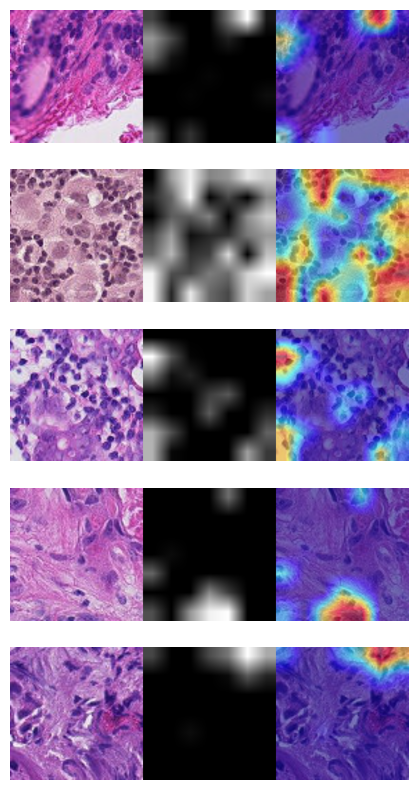

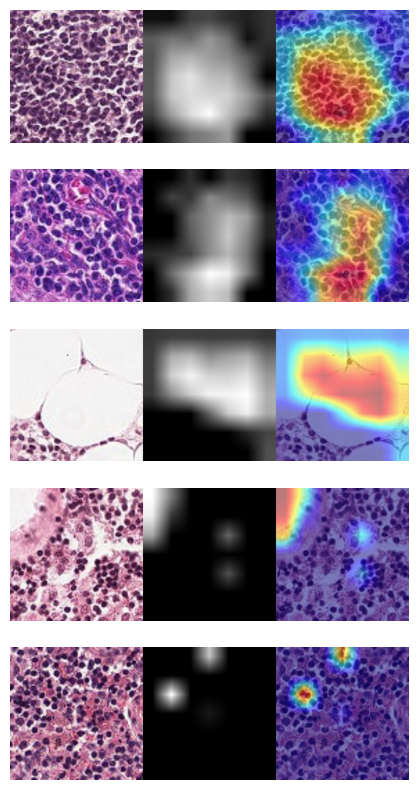

In [5]:
target_layers = [model.resnet.layer4]
make_plots(model, positive_indices, target_layers)
make_plots(model, negative_indices, target_layers, False)

# UNet

In [6]:
path = '../unet_weights/vanilla/*'

# U-Net model with a classification head
class UNet(nn.Module):
    def __init__(self, num_classes=2):
        super(UNet, self).__init__()

        # Encoder (Downsampling path)
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder (Upsampling path)
        self.up4 = self.upconv(1024, 512)
        self.dec4 = self.conv_block(1024, 512)
        self.up3 = self.upconv(512, 256)
        self.dec3 = self.conv_block(512, 256)
        self.up2 = self.upconv(256, 128)
        self.dec2 = self.conv_block(256, 128)
        self.up1 = self.upconv(128, 64)
        self.dec1 = self.conv_block(128, 64)

        # Classification head
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, num_classes)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))

        # Decoder with skip connections
        dec4 = self.dec4(torch.cat([self.up4(bottleneck), enc4], dim=1))
        dec3 = self.dec3(torch.cat([self.up3(dec4), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.up2(dec3), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.up1(dec2), enc1], dim=1))

        # Classification head
        gap = self.gap(dec1)
        out = self.fc(gap.view(gap.size(0), -1))

        return out
    

model = UNet(num_classes=2)  # Binary classification
model = load_model_weights(model, path)

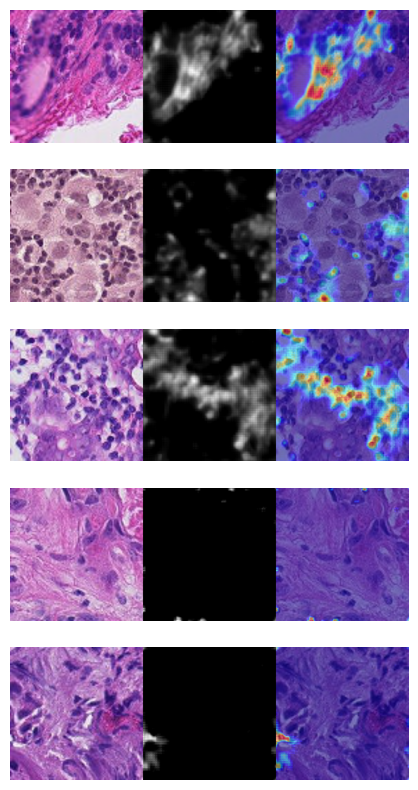

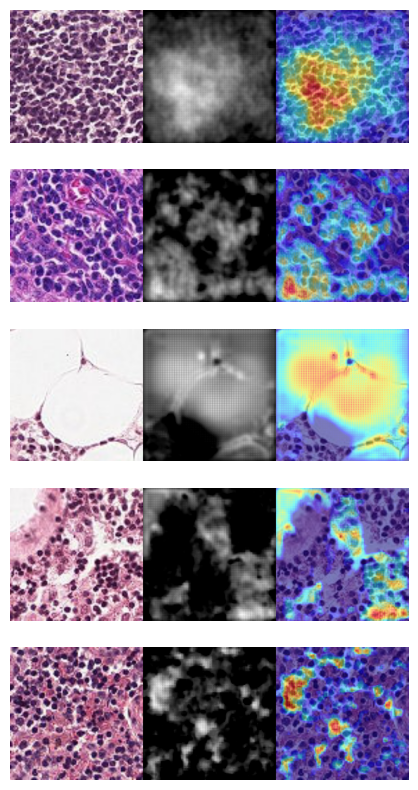

In [7]:
target_layers = [model.up1, model.up2]
make_plots(model, positive_indices, target_layers)
make_plots(model, negative_indices, target_layers, False)

# VIT

In [8]:
path = '../vit_weights/vit_vanilla/*'
model = vit_b_16(pretrained=True)
model.heads = nn.Linear(model.hidden_dim, 2)
model = load_model_weights(model, path)
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

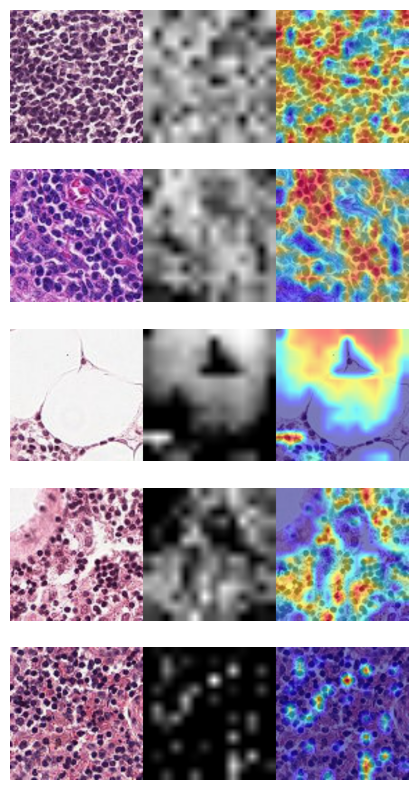

In [12]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
        height, width, tensor.size(2))
    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

target_layers = [model.encoder.layers.encoder_layer_4]
make_plots(model, positive_indices, target_layers, reshape_transform=reshape_transform)
make_plots(model, negative_indices, target_layers, False, reshape_transform)

# Inception net

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import inception_v3, Inception_V3_Weights


path = '../inception_weights/vanilla/*'
model = inception_v3(weights=Inception_V3_Weights.DEFAULT, aux_logits=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = load_model_weights(model, path)
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

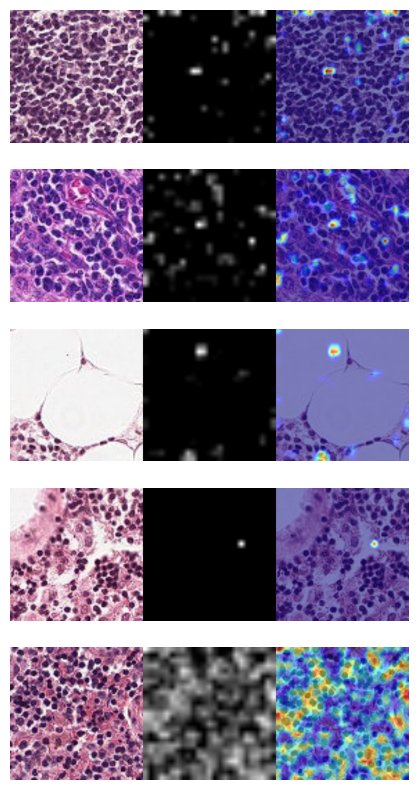

In [15]:
target_layers = [model.Mixed_5b]
make_plots(model, positive_indices, target_layers)
make_plots(model, negative_indices, target_layers, False)

# Efficient Net

In [17]:
from efficientnet_pytorch import EfficientNet

path = '../efficientnet_weights/vanilla/*'
model = EfficientNet.from_pretrained('efficientnet-b0')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 2)

model = load_model_weights(model, path)
model

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

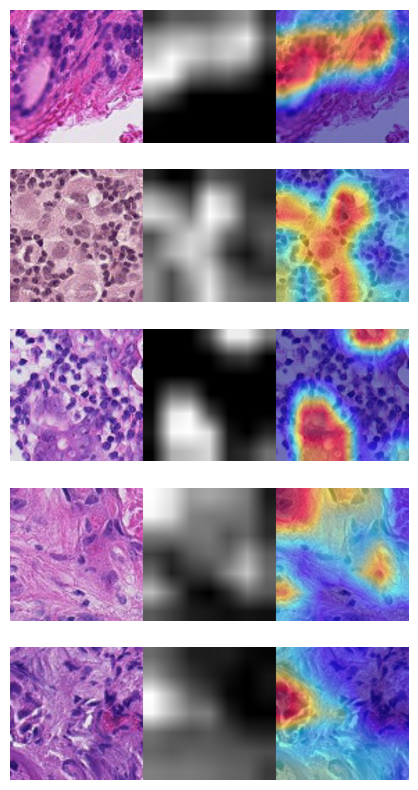

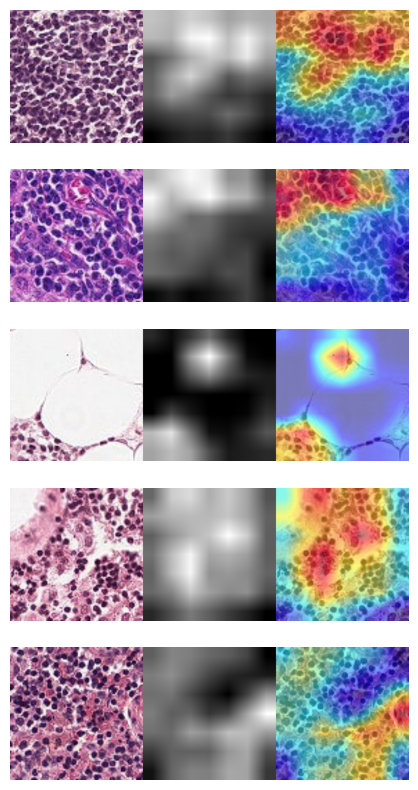

In [18]:
target_layers = [model._conv_head]
make_plots(model, positive_indices, target_layers)
make_plots(model, negative_indices, target_layers, False)